# Navigation

---

This notebook contains the solution implemented for the "Navigation" project based on a Unity's ML-Agents environment. This is the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).



## 1. Solution description

The project solution is composed of this same jupyter notebook and three Python files:

* dqn_agent: Contains the agent that implements the DQN algorithm for learning.
* model: Contains the definition of the model layers and how the data forward is processed from the input layer to the output layer that returns the action to be executed. It also includes a couple of functions to load and save already trained models.
* utils: Contains utility functions.

## 2. Training phase

### 1. Importing the required packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
import math
from datetime import datetime

from dqn_agent import Agent
from utils import moving_average, write_scores

In my particular case I have experienced the following error during model training:

```console
Disposing session as kernel process died ExitCode: 3, Reason: OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
```

After a quick search on the Internet I found the reason for the problem and the solution at [Stack Overflow](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial). The next cell contains the proposed solution.

In [2]:
# Workaround to avoid error #15:
# Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized OMP
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### 2. Setting the model and training parameters 

Next, a series of constants are defined that will allow the model to be parameterized centrally throughout the project. This avoids having to go through different files to configure the parameters and avoids errors in the training phase.

In [3]:
STATE_SIZE = 37             # Size for the input states
ACTION_SIZE = 4             # Number of possible actions
HIDDEN_LAYERS = [64, 32]    # Array for the sizes of the hidden layers
# HIDDEN_LAYERS = [256, 128, 64, 32]

DROP_P = 0.15               # Probability for the dropout layers in the QNetwork

BUFFER_SIZE = int(1e5)      # Replay buffer size
BATCH_SIZE = 64             # Minibatch size
UPDATE_EVERY = 4            # Network update frequency

N_EPISODES = 2000           # Number of episodes
MAX_T = 1000                # Number of timesteps per episode
TRAINING_GOAL = 13.0        # Training goal for the scores mean in an episode

EPS_START = 1.0             # Epsilon initial value
EPS_END =0.1                # Minimum value for Epsilon
EPS_DECAY = 0.995           # Epsilon decay factor
GAMMA = 0.99                # Discount factor
TAU = 1e-3                  # For soft update of target parameters
LR = 5e-4                   # Learning rate 

SEED = 777                  # Seed for the random generator

### 3. Configuring where the model will run
GPU processing is configured whenever possible, a message indicates whether the model will be trained/executed on the CPU or on the GPU using CUDA.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for the processing.")

Using cuda:0 for the processing.


### 4. Starting up the environment
Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [5]:
# Unity environment is instantiated
environment = UnityEnvironment(file_name="Banana_Windows_x86_64\Banana.exe")
agent = Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_layers=HIDDEN_LAYERS, drop_p=DROP_P, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, lr=LR, update_every=UPDATE_EVERY, seed=SEED)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 5. Examining the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

Run the code cell below to print some information about the environment.

In [6]:
# get the default brain
brain_name = environment.brain_names[0]
brain = environment.brains[brain_name]

# reset the environment
env_info = environment.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 6. Running the episodes

The agent executes successive episodes for training until the objective specified in the goal parameter is reached, i.e. an equal or higher value for the average score within an episode is reached.

In [7]:
def run_episodes(env, n_episodes, max_t, eps_start, eps_end, eps_decay, goal):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
        
    # get the default brain
    brain_name = env.brain_names[0]
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)     # the agent choose an action (casted to int to avoid runtime error)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) 
            state = next_state 
            score += reward                           # update the scores
            if done:
                break 
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        if write_scores(i_episode=i_episode, scores_window=scores_window, eps=eps, goal=goal):
            agent.qnetwork_local.save(f"Solver_{math.trunc(datetime.timestamp(datetime.now()))}.pth")
            break
           
    return scores

### 7. Training the model

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Episode 100	Average Score: 0.89	Epsilon: 0.6057704364907278
Episode 200	Average Score: 5.01	Epsilon: 0.36695782172616715
Episode 300	Average Score: 8.19	Epsilon: 0.22229219984074702
Episode 400	Average Score: 10.66	Epsilon: 0.13465804292601349
Episode 453	Average Score: 13.00	Epsilon: 0.10324180238648367
Environment solved in 453 episodes!	Average Score: 13.00
Model saved to model_1651259749.pth.


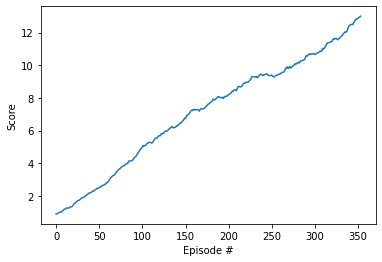

In [8]:
# Call the algorithm execution
scores = run_episodes(environment, N_EPISODES, MAX_T, EPS_START, EPS_END, EPS_DECAY, TRAINING_GOAL)

# Save the trained model
file_path = f"model_{math.trunc(datetime.timestamp(datetime.now()))}.pth"
agent.qnetwork_local.save(file_path)
print(f"Model saved to {file_path}.")

# Unity environment is closed
environment.close()

# Moving averages are used on the plot to reduce noise
medias = moving_average(scores, 10)

# Plot the moving_averages
fig = plt.figure()
ax = fig.add_subplot(111)
medias = moving_average(scores, 100)
plt.plot(np.arange(len(medias)), medias)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 3. Validation phase

### 8. Watching the trained model in action

The trained model will then be loaded and its performance in the Unity environment will be shown:

In [1]:
import torch
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
import math
from datetime import datetime

from dqn_agent import Agent

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for the processing.")

env = UnityEnvironment(file_name="Banana_Windows_x86_64\Banana.exe")

file_path = 'Solver_1651259749.pth'
agent = Agent()
agent.qnetwork_local.load(file_path)
agent.qnetwork_local.to(device)

Using cuda:0 for the processing.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


QNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.5)
)

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment

state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state).astype(int)          # Take an action, casted to int to avoid runtime error<<<<<
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))


Score: 17.0


In [4]:
env.close()

## 4. Conclusions

The agent has achieved the set goal with a simple DQN implementation and in a reasonable number of episodes.

Durante el proceso de entrenamiento he probado distintas configuraciones para la red neuronal variando tanto el tamaño como el número de las capas ocultas.

He comprobado que las configuraciones más sencillas permitían ir subiendo las puntuaciones más rápidamente.

Así mismo, he probado con distintos valores para el decremento de epsilon y para el learning rate hasta que he dado con los que me permitían un aprendizaje más lineal y satisfactorio.

He incluido dropout layers en el modelo con el fin de evitar overfitting. Tras probar distintos valores para el parámetro drop_p, he llegado a un valor que no limitaba la velocidad de aprendizaje.

## 5. Next steps

As an exercise on the sidelines of the project, I will implement other versions of the agent that make use of the improvements seen in the nanodegree, such as:

* Double DQN (DDQN)
* Prioritized experience replay
* Dueling DQN

I will also approach the exercise from the point of view of the analysis of the frames generated by Unity using torchvision, in order to practice with convolutional neural networks and the application of transformations on the images.